# ASL Alphabet classification by CNN [PyTorch].

## Оглавление
   * ### Введение
   * ### Импорт библиотек
   * ### Изображение жестов
   * ### Нормализация данных
   * ### Создание тренировочной и проверочной выборки
   * ### Создание собственной CNN
   * ### Обучение нейронной сети
   * ### Оценка качества нейронной сети
   * ### Сохранение модели

## Введение

**ASL Alphabet -** набор изображений-жестов, обозначающих **латинские буквы алфавита** и **специальные символы**, а именно:
  * **A - Z** (Буквы)
  * **del, space, nothing** (Специальные символы)
  

Суммарное количество уникальных жестов составляет 29 (26 букв и 3 спец.символа).

Мы имеем два набора данных:
  * **Тренировочные данные:** хранят в себе по 3000 тысячи изображений на каждый жест (суммарно 87 000)
  * **Тестовый набор:** хранит по 1 изображению на каждый жест (суммарно 29)

## Импорт библиотек

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import imageio
import os

import torch
from torch import nn, optim
from torchvision import datasets, transforms, models

from pathlib import Path
from PIL import Image

## Изображение жестов

Прежде чем приступить к созданию нейронки, давайте получим информацию об изображениях и то, как выглядит каждый жест.

--------------Информация по изображению--------------
[X] Высота(px): 200
[Y] Ширина(px): 200
[Channels] RGB: 3
-----------------------------------------------------


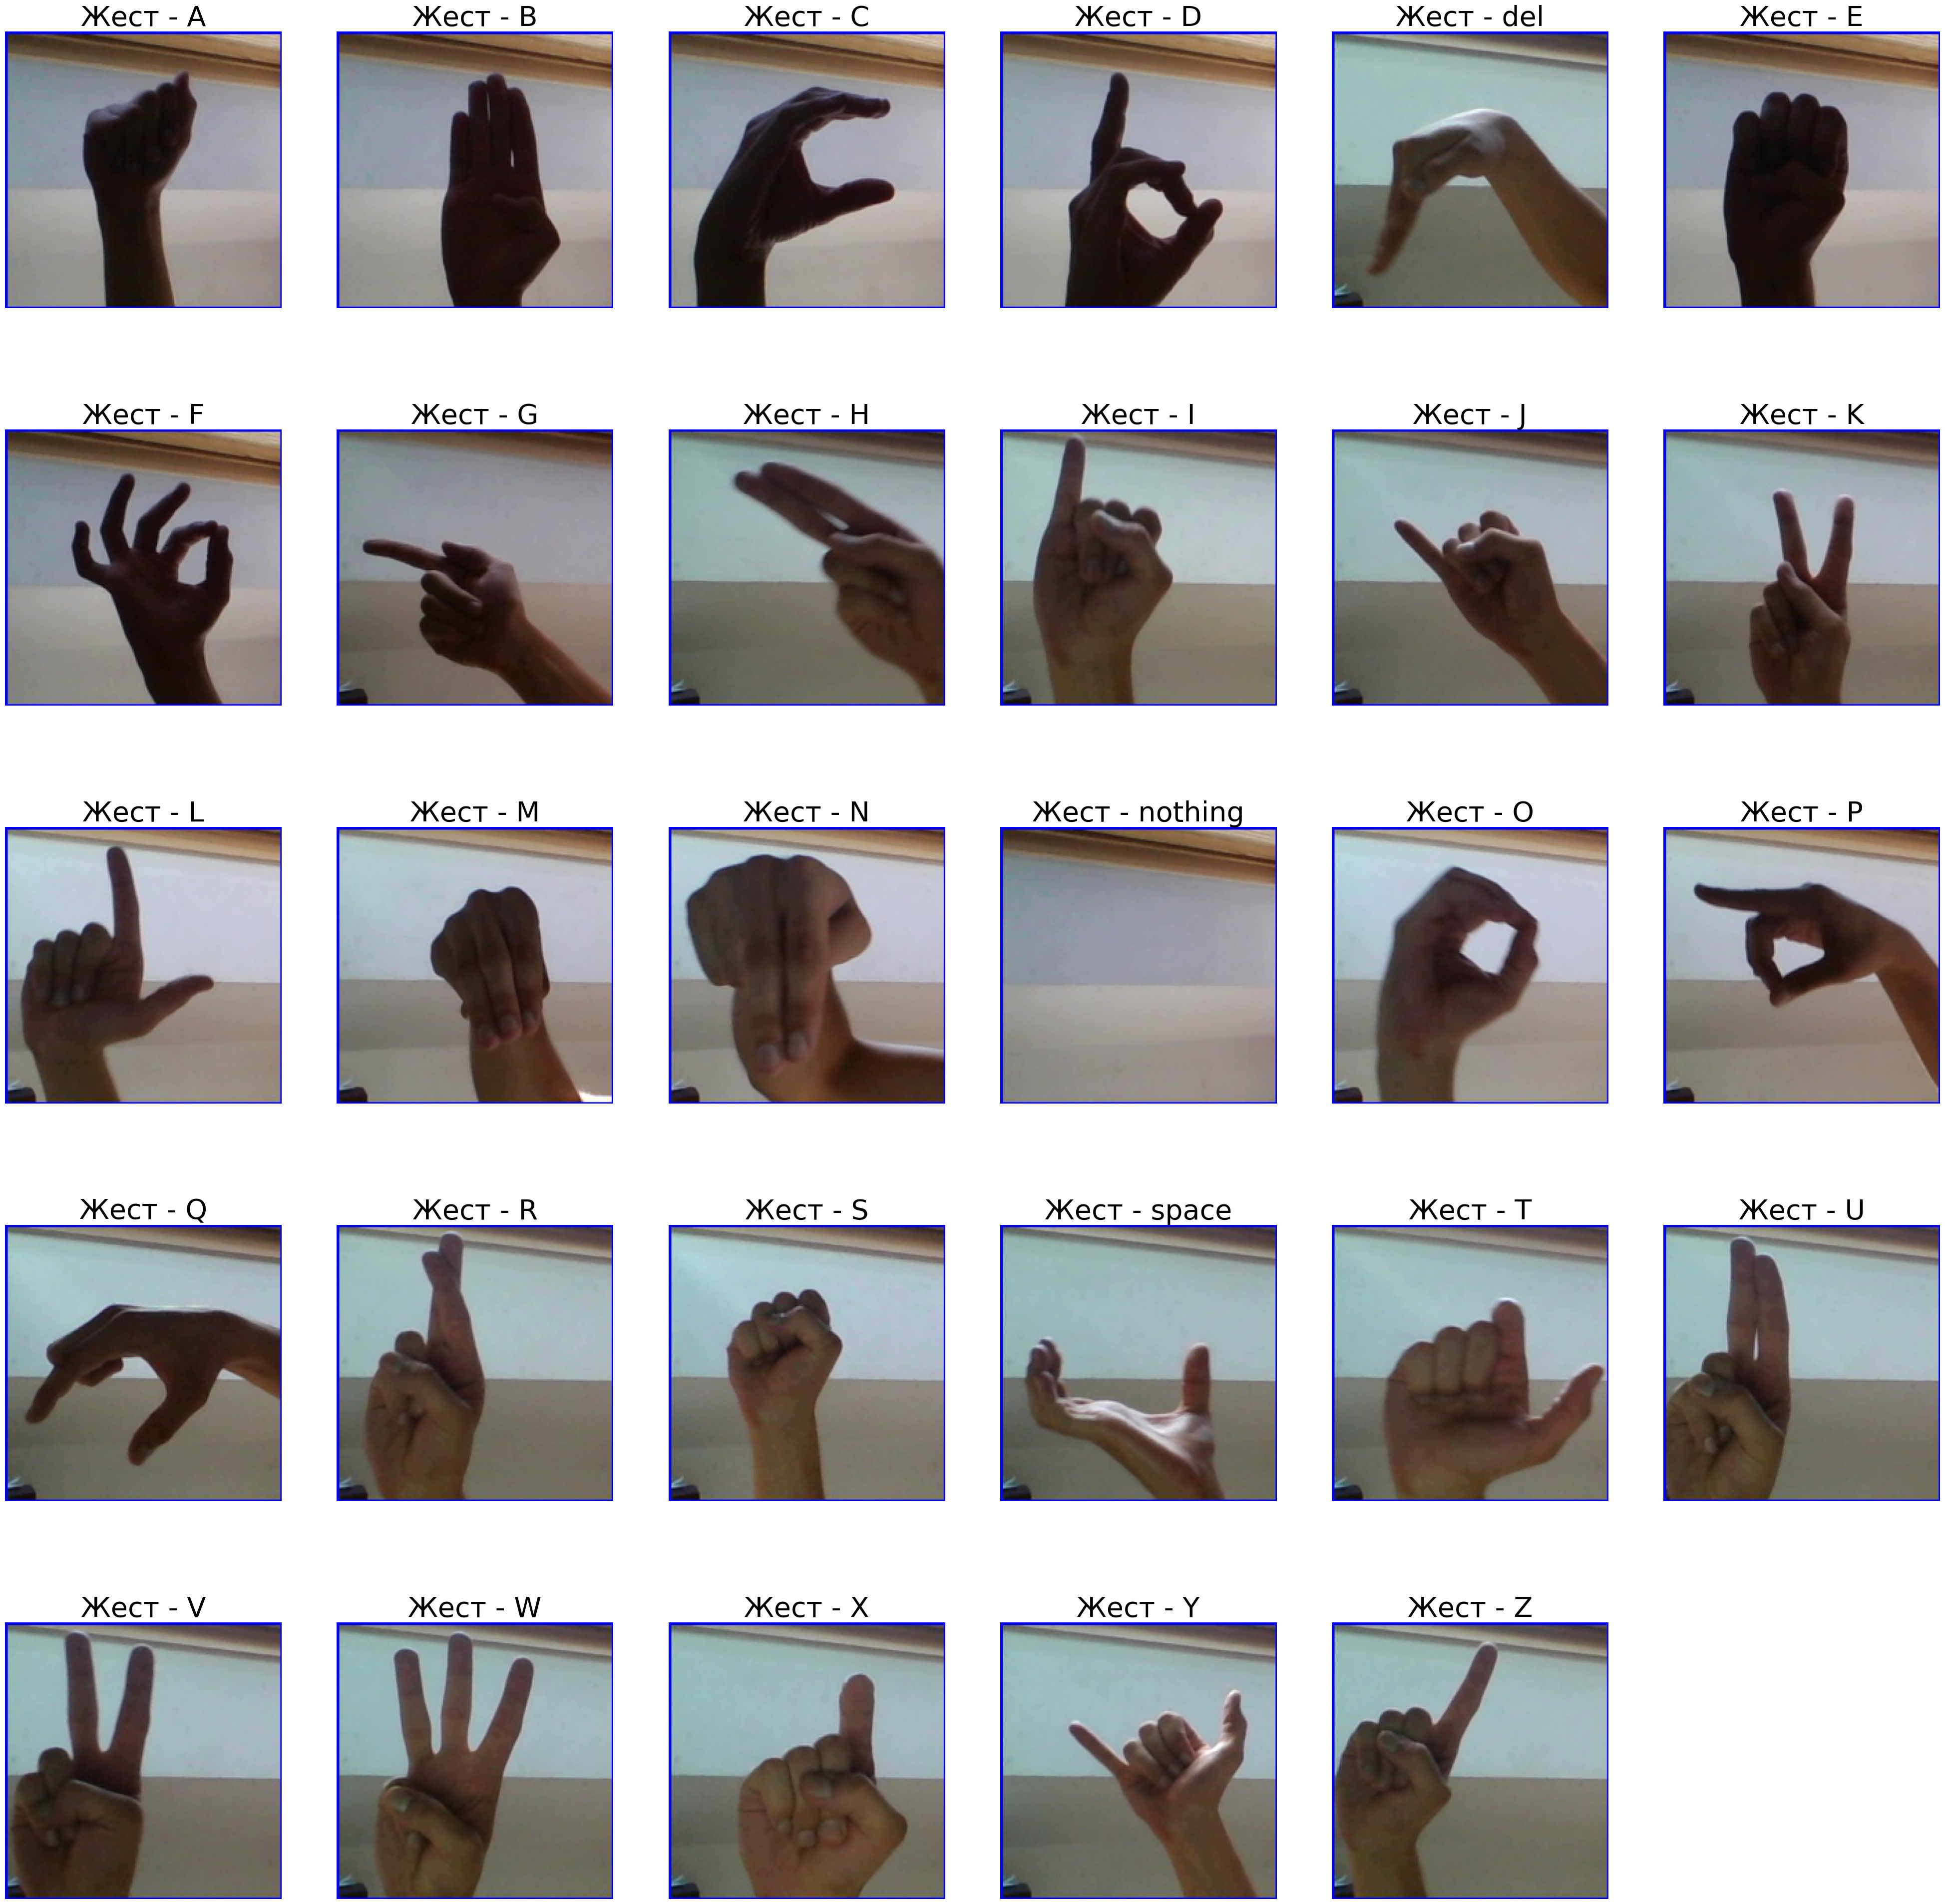

In [2]:
path = 'data/asl_alphabet_train/'
letters_dir_list = os.listdir(path)
img_list = []

for letter in letters_dir_list:
    img_list.append(imageio.imread_v2(f'data/asl_alphabet_train/{letter}/{letter}1.jpg'))

# Делаем словарь {Название жеста: изображение}
img_dict = dict(zip(letters_dir_list, img_list))

"""Предварительно выведем информацию об размерности изображения."""
img = img_dict['A']
img_shape = img.shape
print('--------------Информация по изображению--------------')
print(f'[X] Высота(px): {img_shape[0]}')
print(f'[Y] Ширина(px): {img_shape[1]}')
print(f'[Channels] RGB: {img_shape[2]}')
print('-----------------------------------------------------')

"""Постройка графиков для изображений."""
row, cols = 5, 6
size = 40
figsize = (50, 50)
i, j = 0, 0
figure, axis = plt.subplots(row,
                            cols,
                            figsize=figsize)
figure.delaxes(axis[row-1, cols-1]) # Т.к у нас 29 уникальных изображений, то удаляем последний график.

for img in img_dict:
    axis[i, j].imshow(img_dict[img])
    axis[i, j].axis('off')
    axis[i, j].set_title(f'Жест - {img}',
                         size=size)
    j += 1
    if j == cols:
        j = 0
        i += 1

## Нормализация данных.

Нейронные сети демонстрируют **лучшее качество обучения**, когда входные данные являются числами с **плавующей точкой** и находятся в диапозоне **от 0 до 1 или от -1 до 1**, посему необходимо сделать **нормализацию**

Я воспользуюсь **вторым способом** для этого нам необходимо вычислить **среднее** и **стандартное отклонение** для каждого канала.

In [3]:
"""Создание ненормализованного датасета"""

train_path = 'data/asl_alphabet_train/'

unnormalized_dataset = datasets.ImageFolder(train_path, transform=transforms.ToTensor())
unnormalized_image = unnormalized_dataset[0][0].permute(1, 2, 0)

In [4]:
"""Вычисление mean и std для каждого канала"""

mean, std = 0, 0
len_data = len(unnormalized_dataset)

for img, _ in unnormalized_dataset:
    mean += torch.mean(img, dim=[1, 2])
    std += torch.std(img, dim=[1, 2])
    
mean = mean / len_data
std = std / len_data
print(f'Среднее значение RGB-каналов: {mean}')
print(f'Стандартное отклонение RGB-каналов: {std}')

Среднее значение RGB-каналов: tensor([0.5190, 0.4992, 0.5140])
Стандартное отклонение RGB-каналов: tensor([0.2045, 0.2334, 0.2419])


In [5]:
"""Создание нормализованного датасета"""

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(50),
    transforms.Normalize(mean=mean,
                         std=std)
])

normalized_dataset = datasets.ImageFolder(train_path, transform=transform)
normalized_image = normalized_dataset[0][0].permute(1, 2, 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


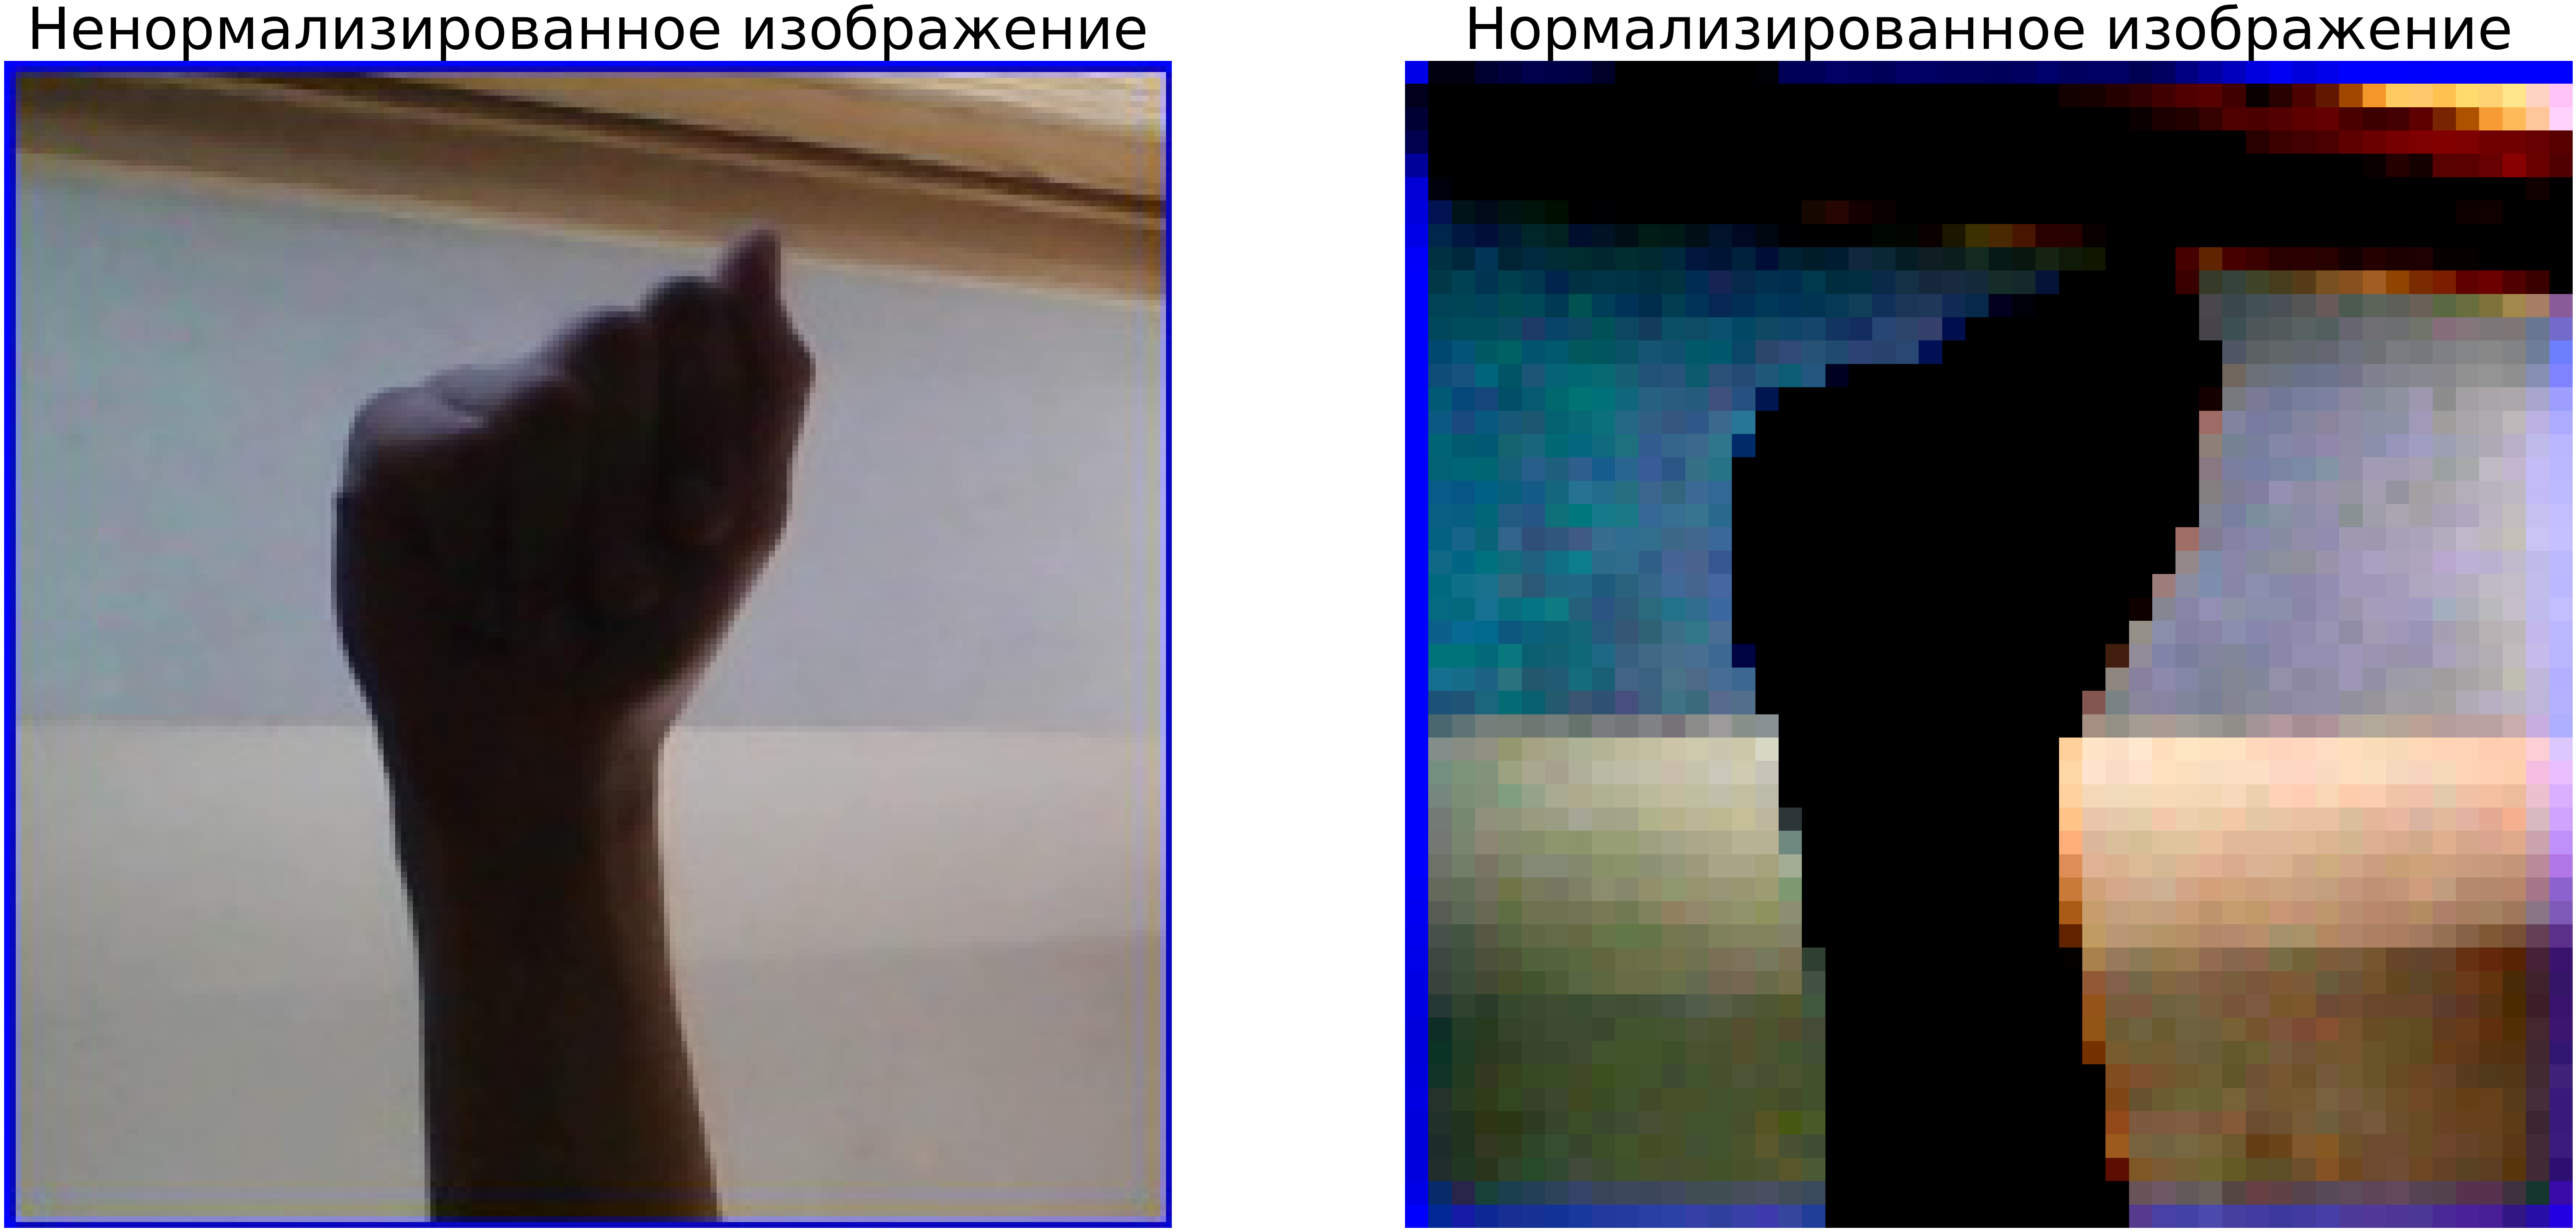

In [6]:
"""Отображение результата работы"""

figure, axis = plt.subplots(1, 2, figsize=(80, 80))

axis[0].axis('off')
axis[0].imshow(unnormalized_image)
axis[0].set_title('Ненормализированное изображение', size=100)

axis[1].axis('off')
axis[1].imshow(normalized_image)
axis[1].set_title('Нормализированное изображение', size=100)

plt.show()

## Создание тренировочной и проверочной выборки

In [7]:
train_size = int(0.8 * len(normalized_dataset))
test_size = len(normalized_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(normalized_dataset, [train_size, test_size])

batch_size = 32

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size,
    shuffle=True
)

test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

classes = train_dataloader.dataset.dataset.classes

## Создание собственной CNN

In [8]:
class AslAlphabetCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=8,
                               kernel_size=3,
                               padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(in_channels=8,
                               out_channels=4,
                               kernel_size=3,
                               padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(in_features=(4*12*12),
                             out_features=29)
        self.act3 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=29,
                             out_features=len(classes))
        
    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 4*12*12) # шаг изменения формы, которая отсутствовала ранее\
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

## Обучение нейронной сети

In [9]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        correct_train = 0
        total_train = 0
        
        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()

        print(f"{datetime.datetime.now()} Epoch {epoch}, Training loss {loss_train / len(train_loader)}")
        
# Подготовка необходимых компонентов.
model = AslAlphabetCNN()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 50,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_dataloader)

2023-02-25 01:05:22.823868 Epoch 1, Training loss 2.7144644652289904
2023-02-25 01:07:18.556214 Epoch 2, Training loss 1.7266194685574237
2023-02-25 01:09:13.429438 Epoch 3, Training loss 1.1540353309697118
2023-02-25 01:11:08.385905 Epoch 4, Training loss 0.810737202674493
2023-02-25 01:13:03.212916 Epoch 5, Training loss 0.6096537477668674
2023-02-25 01:14:58.030738 Epoch 6, Training loss 0.4857068290381596
2023-02-25 01:16:53.894862 Epoch 7, Training loss 0.3952472627402722
2023-02-25 01:18:49.472918 Epoch 8, Training loss 0.33103366361267267
2023-02-25 01:20:44.932797 Epoch 9, Training loss 0.2763378074962175
2023-02-25 01:22:40.451829 Epoch 10, Training loss 0.2448652931516883
2023-02-25 01:24:35.207170 Epoch 11, Training loss 0.21474612977227261
2023-02-25 01:26:30.502918 Epoch 12, Training loss 0.18911390150672402
2023-02-25 01:28:25.487483 Epoch 13, Training loss 0.17238486268354217
2023-02-25 01:30:20.705352 Epoch 14, Training loss 0.15531499941030452
2023-02-25 01:32:15.96653

## Оценка качества нейронной сети

In [10]:
def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("test", val_loader)]:
        correct = 0
        total = 0
        
        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
                
        print(f"Accuracy {name}: {np.round((correct / total), 2)}")
        
validate(model, train_dataloader, test_dataloader)

Accuracy train: 0.99
Accuracy test: 0.99


In [11]:
test_data_path = Path('data/asl_alphabet_test/')

class ASLTestDataset(torch.utils.data.Dataset):
    def __init__(self, root_path, transforms=None):
        super().__init__()
        
        self.transforms = transforms
        self.imgs = sorted(list(Path(root_path).glob('*.jpg')))
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        img = Image.open(img_path).convert('RGB')
        
        label = img_path.parts[-1].split('_')[0]
        if self.transforms:
            img = self.transforms(img)
        
        return img, label

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

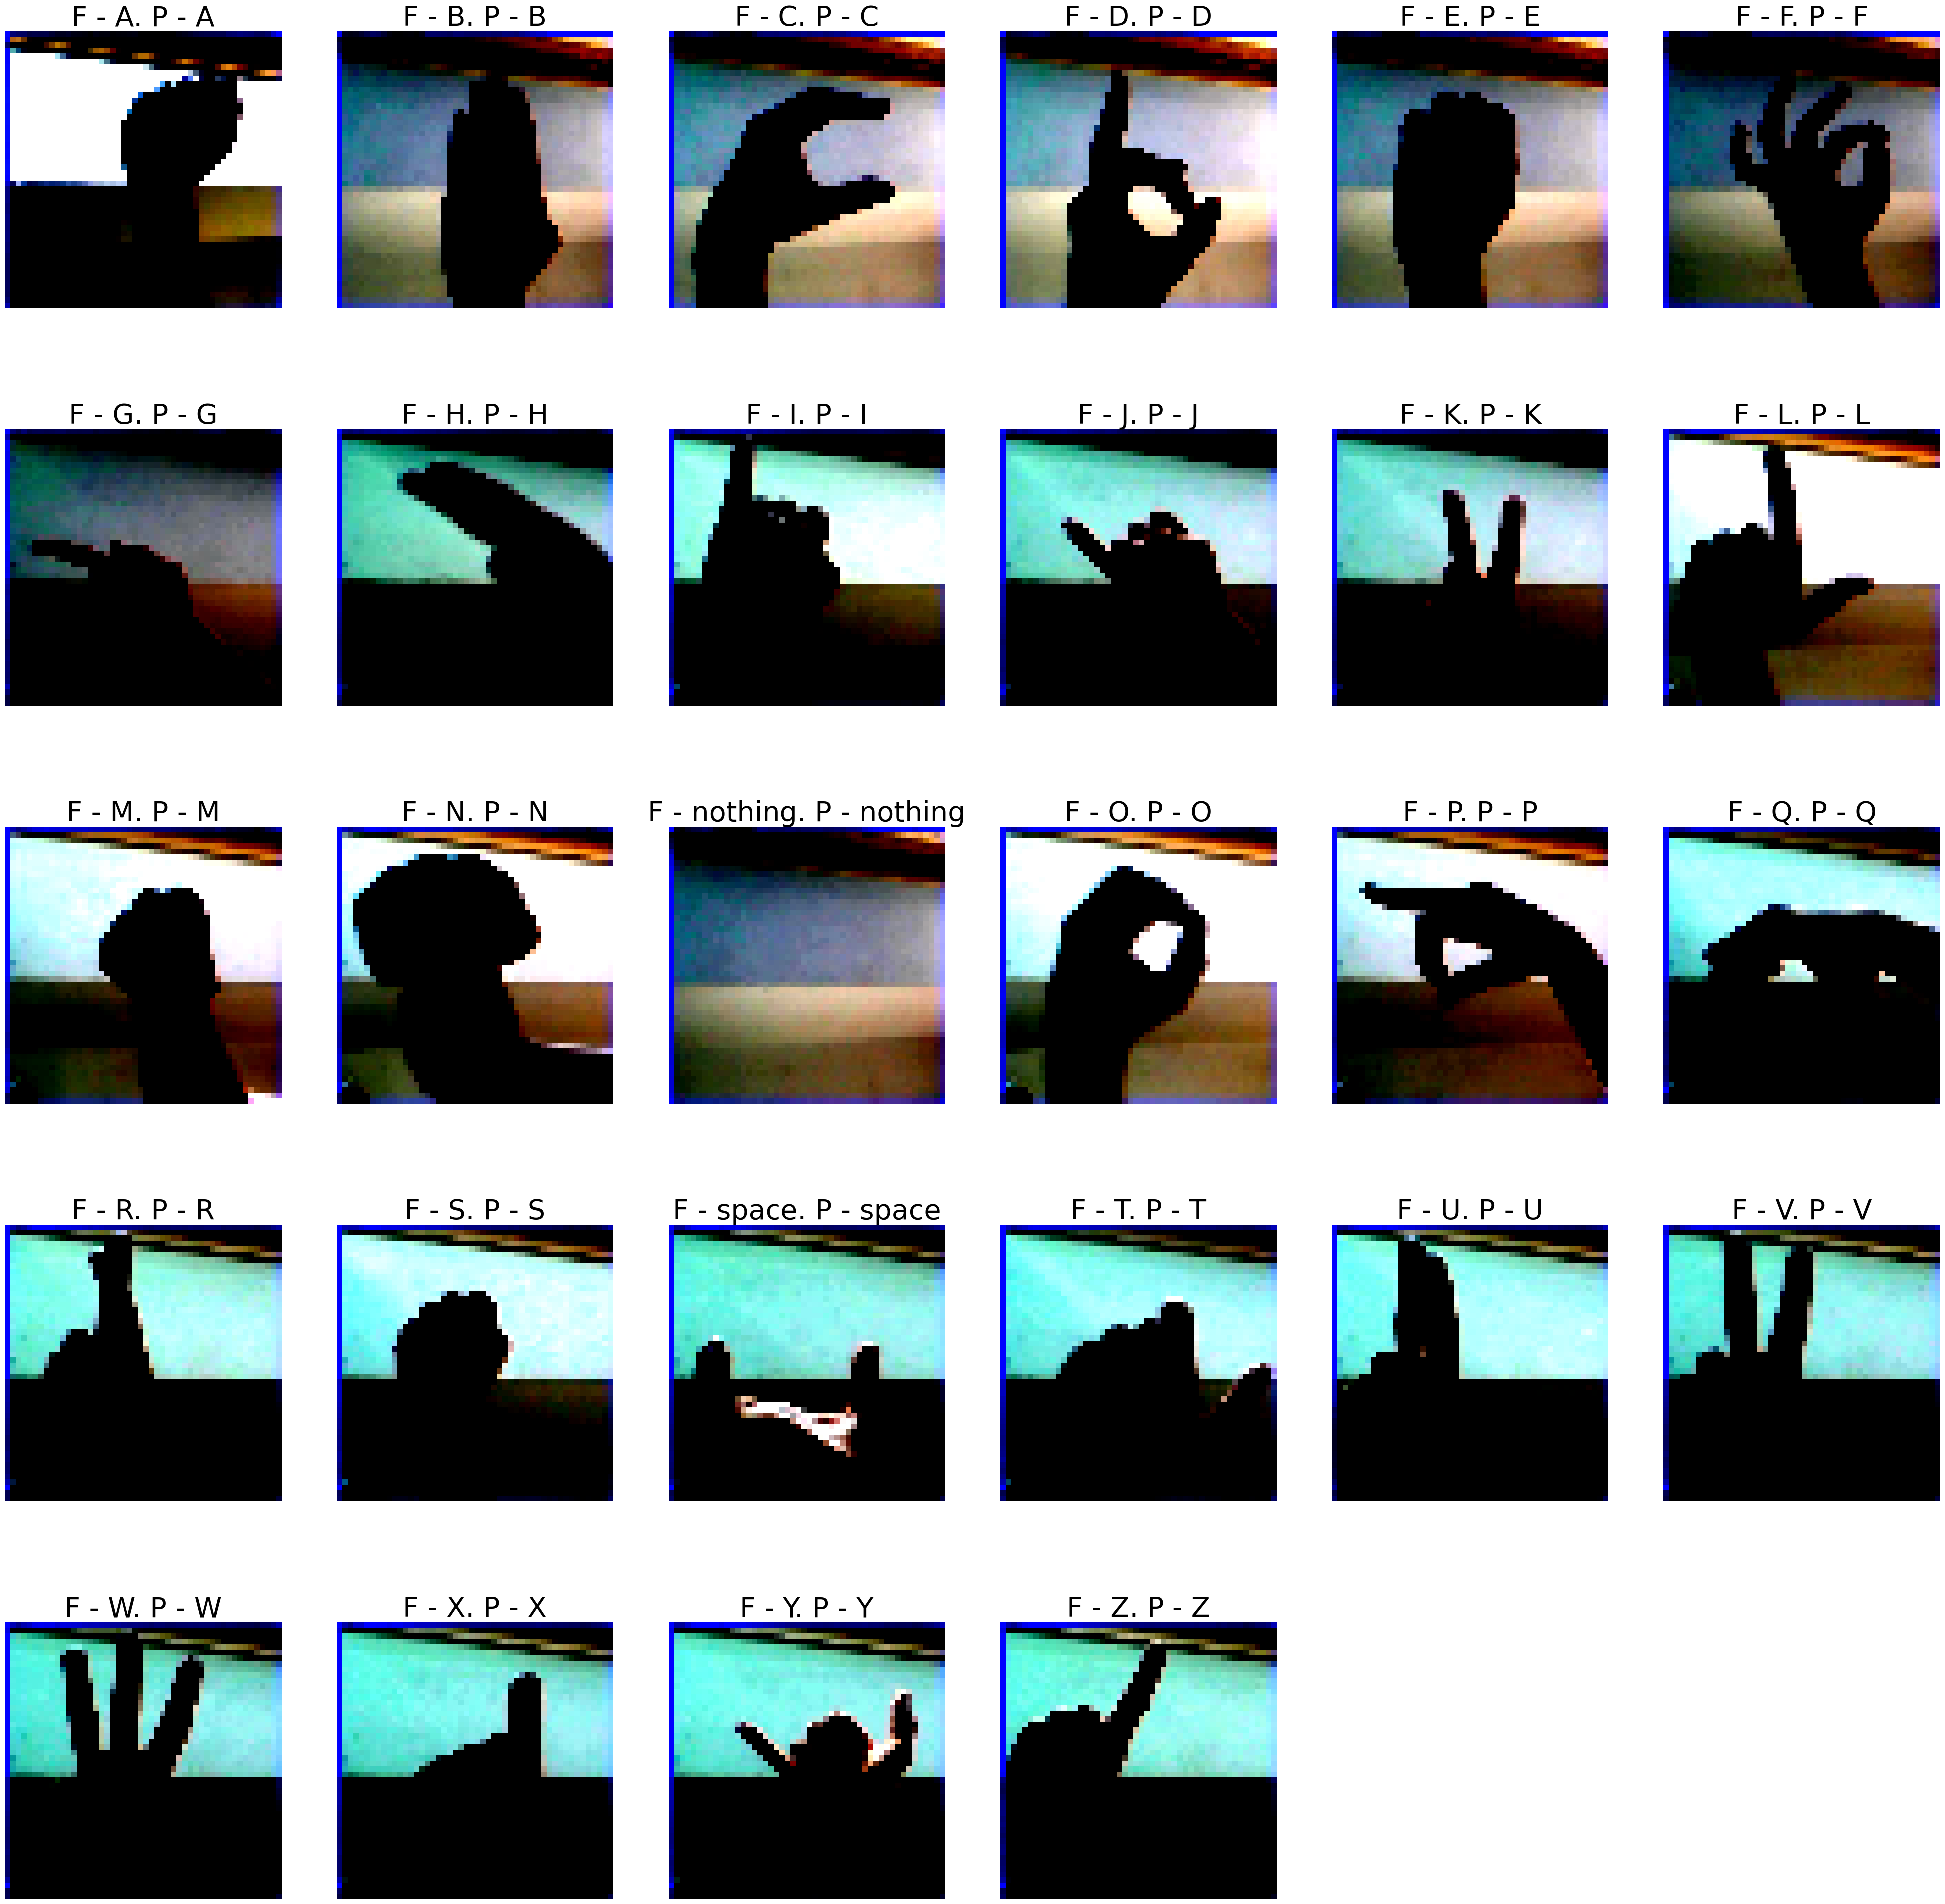

In [12]:
test_dataset = ASLTestDataset(test_data_path, transforms=transform)

row, cols = 5, 6
size = 40
figsize = (50, 50)
fig, axis = plt.subplots(row, cols, figsize=figsize)
fig.delaxes(axis[row-1, cols-1])
fig.delaxes(axis[row-1, cols-2])
i, j = 0, 0
for img, label in test_dataset:
    prediction = model(img)

    axis[i][j].imshow(img.permute(1, 2, 0))
    axis[i][j].set_title(f'F - {label}. P - {classes[torch.max(prediction, dim=1)[1]]}', size=size)
    axis[i][j].axis('off')
    j += 1
    if j == cols:
        j = 0
        i += 1
        
plt.show()

## Сохранение модели

In [13]:
save_path = 'data/pretrained_model/'
torch.save(model.state_dict(), save_path + 'asl_alphabet_cnn.pt')

# Убедимся в работоспособности.
loaded_model = AslAlphabetCNN()
loaded_model.load_state_dict(torch.load(save_path + 'asl_alphabet_cnn.pt'))

validate(loaded_model, train_dataloader, test_dataloader)

Accuracy train: 0.99
Accuracy test: 0.99
